# PySpark Installation for Google Colab

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
version = "3.5.3"
!wget https://downloads.apache.org/spark/spark-{version}/spark-{version}-bin-hadoop3.tgz

--2024-12-13 18:54:10--  https://downloads.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.208.237, 135.181.214.104, 2a01:4f9:3a:2c57::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.208.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400864419 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.3-bin-hadoop3.tgz’

spark-3.5.3-bin-had 100%[===================>] 382.29M  18.2MB/s    in 22s     

2024-12-13 18:54:33 (17.4 MB/s) - ‘spark-3.5.3-bin-hadoop3.tgz’ saved [400864419/400864419]



In [ ]:
!tar xzvf spark-{version}-bin-hadoop3.tgz

spark-3.5.3-bin-hadoop3/
spark-3.5.3-bin-hadoop3/data/
spark-3.5.3-bin-hadoop3/data/graphx/
spark-3.5.3-bin-hadoop3/data/graphx/users.txt
spark-3.5.3-bin-hadoop3/data/graphx/followers.txt
spark-3.5.3-bin-hadoop3/data/mllib/
spark-3.5.3-bin-hadoop3/data/mllib/sample_linear_regression_data.txt
spark-3.5.3-bin-hadoop3/data/mllib/sample_fpgrowth.txt
spark-3.5.3-bin-hadoop3/data/mllib/sample_libsvm_data.txt
spark-3.5.3-bin-hadoop3/data/mllib/gmm_data.txt
spark-3.5.3-bin-hadoop3/data/mllib/kmeans_data.txt
spark-3.5.3-bin-hadoop3/data/mllib/streaming_kmeans_data_test.txt
spark-3.5.3-bin-hadoop3/data/mllib/sample_lda_data.txt
spark-3.5.3-bin-hadoop3/data/mllib/sample_multiclass_classification_data.txt
spark-3.5.3-bin-hadoop3/data/mllib/pagerank_data.txt
spark-3.5.3-bin-hadoop3/data/mllib/sample_isotonic_regression_libsvm_data.txt
spark-3.5.3-bin-hadoop3/data/mllib/sample_lda_libsvm_data.txt
spark-3.5.3-bin-hadoop3/data/mllib/sample_movielens_data.txt
spark-3.5.3-bin-hadoop3/data/mllib/pic_data

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/spark-{version}-bin-hadoop3"

In [ ]:
import findspark
findspark.init()

# Common Imports

In [ ]:
import pandas as pd
import altair as alt
import datetime
from collections import Counter
from tqdm import tqdm
from itertools import product
from IPython.display import Image, display
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, precision_recall_curve

from pyspark.sql import SparkSession, Row
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Tokenizer, StopWordsRemover, HashingTF, IDF, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Loading the data and doing some EDA

In [33]:
spark = SparkSession.builder.getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

In [34]:
# Reading the wiki edits file
edits_df = spark.read.json("data/edits.json")
print(edits_df.count())
edits_df.printSchema()

40000
root
 |-- $schema: string (nullable = true)
 |-- bot: double (nullable = true)
 |-- comment: string (nullable = true)
 |-- id: double (nullable = true)
 |-- length: struct (nullable = true)
 |    |-- new: long (nullable = true)
 |    |-- old: long (nullable = true)
 |-- log_action: string (nullable = true)
 |-- log_action_comment: string (nullable = true)
 |-- log_id: double (nullable = true)
 |-- log_params: string (nullable = true)
 |-- log_type: string (nullable = true)
 |-- meta: struct (nullable = true)
 |    |-- domain: string (nullable = true)
 |    |-- dt: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- offset: long (nullable = true)
 |    |-- partition: long (nullable = true)
 |    |-- request_id: string (nullable = true)
 |    |-- stream: string (nullable = true)
 |    |-- topic: string (nullable = true)
 |    |-- uri: string (nullable = true)
 |-- minor: double (nullable = true)
 |-- namespace: double (nullable = true)
 |-- notify_url: string 

In [35]:
@F.udf(returnType=IntegerType())
def length_diff_udf(length_col):
    """Helper UDF to compute length_diff feature"""
    if isinstance(length_col, dict):
        return length_col.get('new', 0) - length_col.get('old', 0)
    return 0


@F.udf(returnType=IntegerType())
def hour_of_activity_udf(timestamp):
    """Extract hour of activity from a UNIX timestamp."""
    if timestamp:
        return datetime.datetime.fromtimestamp(timestamp).hour
    return None


@F.udf(returnType=IntegerType())
def day_of_week_activity_udf(timestamp):
    """Extract day of the week (0 for Monday, 6 for Sunday) from a UNIX timestamp."""
    if timestamp:
        return datetime.datetime.fromtimestamp(timestamp).weekday()
    return None


@F.udf(returnType=IntegerType())
def time_diff_udf(prev_timestamp, curr_timestamp):
    """Calculate time difference between two consecutive timestamps."""
    if prev_timestamp and curr_timestamp:
        return int(curr_timestamp - prev_timestamp)
    return None


@F.udf(returnType=IntegerType())
def action_concentration_udf(action_timestamps):
    """Calculate action concentration based on actions within a 5-minute window."""
    if action_timestamps:
        sorted_times = sorted(action_timestamps)
        bursts = [sorted_times[i] - sorted_times[i - 1] <= 300 for i in range(1, len(sorted_times))]
        return sum(bursts)  # Count actions within the 5-minute window
    return 0


@F.udf(returnType=IntegerType())
def namespace_diversity_udf(namespace_list):
    """Count unique namespace values for a user."""
    if namespace_list:
        return len(set(namespace_list))
    return 0


@F.udf(returnType=IntegerType())
def action_diversity_udf(action_list):
    """Count unique action types for a user."""
    if action_list:
        return len(set(action_list))
    return 0

In [38]:
edits_df = edits_df.withColumn(
    "timestamp", (F.col("timestamp") / 1000).cast("long")
)

In [39]:
user_window = Window.partitionBy("user").orderBy("timestamp")
df = edits_df.filter(
    F.col("user").isNotNull()
    & F.col("bot").isNotNull()
).select(
    F.col("user"),
    F.col("bot").cast("int").alias("bot"), # target that we try to predict
    F.col("type"),
    F.col("namespace").cast("int").alias("namespace"),
    F.col("comment"),
    F.length(F.col("comment")).alias("comment_length"),
    length_diff_udf(F.col("length")).alias("length_diff"),
    hour_of_activity_udf(F.col("timestamp")).alias("hour_of_activity"),
    day_of_week_activity_udf(F.col("timestamp")).alias("day_of_week_activity"),
    time_diff_udf(F.lag("timestamp").over(user_window), F.col("timestamp")).alias("time_between_actions"),
    action_concentration_udf(F.collect_list("timestamp").over(user_window)).alias("action_concentration"),
    namespace_diversity_udf(F.collect_list("namespace").over(user_window)).alias("namespace_diversity"),
    action_diversity_udf(F.collect_list("log_action").over(user_window)).alias("action_diversity")
).distinct()
print(df.count())
df.show(5)

37215
+--------------------+---+----------+---------+--------------------+--------------+-----------+----------------+--------------------+--------------------+--------------------+-------------------+----------------+
|                user|bot|      type|namespace|             comment|comment_length|length_diff|hour_of_activity|day_of_week_activity|time_between_actions|action_concentration|namespace_diversity|action_diversity|
+--------------------+---+----------+---------+--------------------+--------------+-----------+----------------+--------------------+--------------------+--------------------+-------------------+----------------+
|      78.211.134.151|  0|categorize|       14|[[:Domenico Botto...|            45|          0|              16|                   5|                   0|                   4|                  1|               0|
|       91.135.221.27|  0|categorize|       14|[[:Корнуоллис Мод...|            63|          0|              15|                   5|         

In [40]:
print("Total distinct bot users:", df.filter(F.col("bot") == 1).select("user").distinct().count())
print("Total distinct human users:", df.filter(F.col("bot") == 0).select("user").distinct().count())
print("Total distinct users than are both human and bot:", df.groupBy("user").agg(F.size(F.collect_set(F.col("bot"))).alias("cnt")).filter(F.col("cnt") > 1).count())

Total distinct bot users: 159
Total distinct human users: 4586
Total distinct users than are both human and bot: 41


In [41]:
from pyspark.sql.window import Window

w = Window.partitionBy('user').orderBy(F.rand(seed=42))
df = df.withColumn('rand_row', F.row_number().over(w))
df = df.filter(F.col("rand_row") == 1).drop("rand_row")

bot_false = df.filter(F.col("bot") == 0).limit(300)
bot_true = df.filter(F.col("bot") == 1)
df = bot_false.union(bot_true)

df.show(5)

+------------------+---+----------+---------+--------------------+--------------+-----------+----------------+--------------------+--------------------+--------------------+-------------------+----------------+
|              user|bot|      type|namespace|             comment|comment_length|length_diff|hour_of_activity|day_of_week_activity|time_between_actions|action_concentration|namespace_diversity|action_diversity|
+------------------+---+----------+---------+--------------------+--------------+-----------+----------------+--------------------+--------------------+--------------------+-------------------+----------------+
|!bbqribsandfish23!|  0|      edit|        0|changed spaces an...|            26|          0|              16|                   5|                NULL|                   0|                  1|               0|
| "quasi" tuttologo|  0|      edit|        0|/* Accoglienza */...|            25|          0|              14|                   5|                NULL|    

In [42]:
# Train / Test split, roughly 90/10 and not allowing the same user to appear in both parts
df = df.withColumn("is_test", F.lit((F.hash(F.col("user")) % 10 == 0)))

train_df = df.filter(F.col("is_test") == 0)
test_df = df.filter(F.col("is_test") == 1)

train_df.show(3)
test_df.show(3)

+-----------------+---+----------+---------+--------------------+--------------+-----------+----------------+--------------------+--------------------+--------------------+-------------------+----------------+-------+
|             user|bot|      type|namespace|             comment|comment_length|length_diff|hour_of_activity|day_of_week_activity|time_between_actions|action_concentration|namespace_diversity|action_diversity|is_test|
+-----------------+---+----------+---------+--------------------+--------------+-----------+----------------+--------------------+--------------------+--------------------+-------------------+----------------+-------+
|"quasi" tuttologo|  0|      edit|        0|/* Accoglienza */...|            25|          0|              14|                   5|                NULL|                   0|                  1|               0|  false|
|           'Inyan|  0|      edit|        0|/* Genèse 38 chez...|            57|          0|              16|                   

In [43]:
# Validating that the same bot doesn't appear in both train and test
df.filter(F.col("bot") == 1).groupby("user").agg(F.size(F.collect_set(F.col("is_test"))).alias("cnt")).filter("cnt > 1").show()

+----+---+
|user|cnt|
+----+---+
+----+---+



In [44]:
# Checking splits
df.groupBy("is_test").count().show() # overall train/test split counts
df.groupBy("bot", "is_test").count().show() # users train/test split counts

+-------+-----+
|is_test|count|
+-------+-----+
|   true|   48|
|  false|  383|
+-------+-----+

+---+-------+-----+
|bot|is_test|count|
+---+-------+-----+
|  0|  false|  265|
|  0|   true|   35|
|  1|  false|  118|
|  1|   true|   13|
+---+-------+-----+



In [45]:
def get_histogram(df):
    return alt.Chart(df).mark_bar().encode(
        x=alt.X("bot:N", title="Bot Flag", axis=alt.Axis(labelAngle=0)),
        y=alt.Y("count:Q", title="Count"),
        color=alt.Color("bot:N"),
    ).properties(
        width=300,
        height=300
    )

In [46]:
def get_donut(df):
    return alt.Chart(df).mark_arc(innerRadius=50).encode(
        theta=alt.Theta("count:Q", title="Count"),
        color=alt.Color("bot:N", title="Bot Flag"),
        tooltip=[
            alt.Tooltip("count:Q", title="Count"),
            alt.Tooltip("pct:Q", title="Ratio", format="0.2%")
        ]
    ).properties(
        width=300,
        height=300
    )

In [47]:
def plot_user_distributions(df, title):
    pd_df = df.groupBy("bot").count().toPandas()
    pd_df["bot"] = pd_df["bot"].astype("bool")
    pd_df["pct"] = round(pd_df['count'] / pd_df['count'].sum(), 4)

    # Disable Altairs limit of 5000 records
    alt.data_transformers.disable_max_rows()

    # Plotting
    return (get_histogram(pd_df) | get_donut(pd_df)).properties(
        title=alt.Title(
            f"Distribution of users in {title} per bot/human",
            anchor="middle",
            fontSize=16
        )
    )

In [48]:
plot_user_distributions(edits_df, "whole edits df")

alt.HConcatChart(...)

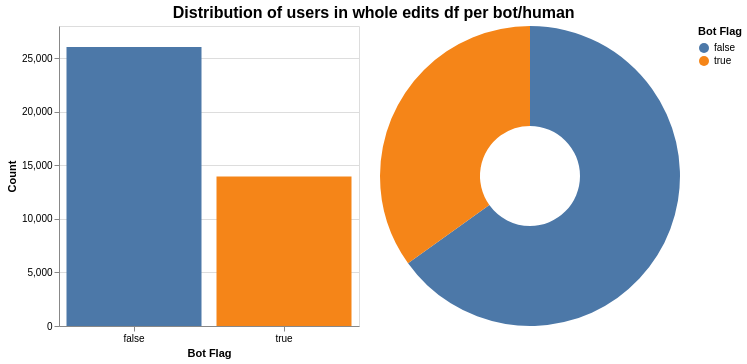

In [64]:
display(Image(filename='./images/edits_df_user_distribution.png'))  # For GitHub

In [50]:
plot_user_distributions(df, "filtered df")

alt.HConcatChart(...)

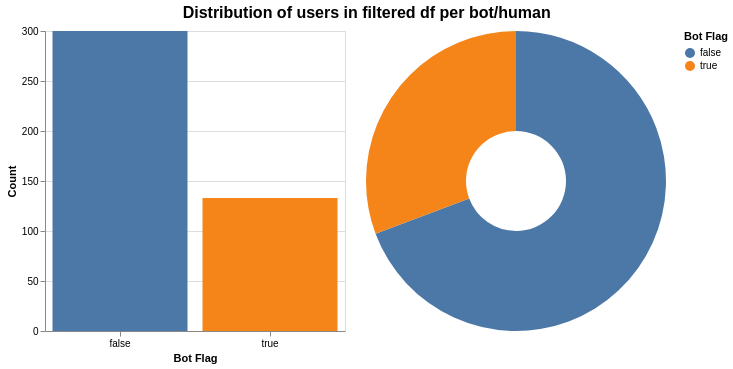

In [ ]:
display(Image(filename='./images/filtered_df_user_distribution.png'))  # For GitHub

# Preparing the model

In [51]:
def create_pipeline(numFeatures, numTrees, maxDepth):
    """Returns a pipeline for bot classification on wiki edits, with customizable parameters"""

    # Encoding 'type' and 'namespace' columns
    type_indexer = StringIndexer(inputCol="type", outputCol="type_index", handleInvalid="keep")
    namespace_indexer = StringIndexer(inputCol="namespace", outputCol="namespace_index", handleInvalid="keep")
    type_encoder = OneHotEncoder(inputCol="type_index", outputCol="type_encoded")
    namespace_encoder = OneHotEncoder(inputCol="namespace_index", outputCol="namespace_encoded")

    # TF-IDF on 'comment'
    tokenizer = Tokenizer(inputCol="comment", outputCol="words")
    stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
    hashing_tf = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=numFeatures)
    idf = IDF(inputCol="raw_features", outputCol="tfidf_features")

    # Assembling all features into a single vector
    assembler = VectorAssembler(
      inputCols=["length_diff", "comment_length", "type_encoded", "namespace_encoded", "tfidf_features"],
      outputCol="features"
    )

    # Defining classifier model
    rf = RandomForestClassifier(labelCol="bot", featuresCol="features", seed=42, numTrees=numTrees, maxDepth=maxDepth)

    # Building and returning the pipeline
    return Pipeline(stages=[
      type_indexer, namespace_indexer,
      type_encoder, namespace_encoder,
      tokenizer, stopwords_remover, hashing_tf, idf,
      assembler, rf
    ])

In [52]:
def fit_predict(train_df, test_df, numFeatures, numTrees, maxDepth, evaluate=True):
    """
        Fits the classifier model on train_df and runs prediction on test_df
        returns the model, predictions dataframe evaluation metrics (optionally)
    """
    pipeline = create_pipeline(numFeatures, numTrees, maxDepth)

    model = pipeline.fit(train_df) # training the classifier
    predictions = model.transform(test_df) # predicting

    # Evaluating
    if not evaluate:
        return model, predictions, None

    evaluation_results = {
        "areaUnderROC": BinaryClassificationEvaluator(labelCol="bot", rawPredictionCol="prediction", metricName="areaUnderROC").evaluate(predictions),
        "areaUnderPR": BinaryClassificationEvaluator(labelCol="bot", rawPredictionCol="prediction", metricName="areaUnderPR").evaluate(predictions)
    }
    for metric in ("f1", "accuracy", "weightedPrecision", "weightedRecall"):
        evaluator = MulticlassClassificationEvaluator(labelCol="bot", predictionCol="prediction", metricName=metric)
        evaluation_results[metric] = evaluator.evaluate(predictions)

    return model, predictions, evaluation_results

In [53]:
# Define parameters grid
params = {
    "numFeatures": [100, 500, 1000],
    "numTrees": [10, 50, 100],
    "maxDepth": [5, 10, 20]
}

In [54]:
results = []
for numFeatures, numTrees, maxDepth in tqdm(product(params["numFeatures"], params["numTrees"], params["maxDepth"]),
                                            total=len(params["numFeatures"]) * len(params["numTrees"]) * len(params["maxDepth"])):

      _, _, res = fit_predict(train_df, test_df, numFeatures, numTrees, maxDepth, evaluate=True)
      results.append(Row(
          numFeatures=numFeatures, numTrees=numTrees, maxDepth=maxDepth,
          f1_score=round(res["f1"], 2), accuracy=round(res["accuracy"], 2),
          precision=round(res["weightedPrecision"], 2), recall=round(res["weightedRecall"], 2),
          areaUnderROC=round(res["areaUnderROC"], 2), areaUnderPR=round(res["areaUnderPR"], 2)
      ))

100%|██████████| 27/27 [23:02<00:00, 51.20s/it]


In [55]:
# View the grid search results ordered by best f1 score
results_df = spark.createDataFrame(results)
results_df.orderBy(F.desc("f1_score")).show()

+-----------+--------+--------+--------+--------+---------+------+------------+-----------+
|numFeatures|numTrees|maxDepth|f1_score|accuracy|precision|recall|areaUnderROC|areaUnderPR|
+-----------+--------+--------+--------+--------+---------+------+------------+-----------+
|       1000|      10|      20|    0.85|    0.85|     0.85|  0.85|        0.78|        0.7|
|        500|     100|      20|    0.85|    0.85|     0.85|  0.85|         0.8|       0.68|
|        100|      10|      10|    0.85|    0.85|     0.85|  0.85|         0.8|       0.68|
|       1000|     100|      20|    0.85|    0.85|     0.85|  0.85|        0.78|        0.7|
|        500|      10|       5|    0.83|    0.85|     0.88|  0.85|        0.73|        0.8|
|        100|      10|      20|    0.83|    0.83|     0.83|  0.83|        0.79|       0.63|
|       1000|      50|      20|    0.83|    0.83|     0.83|  0.83|        0.76|       0.64|
|        500|      50|      10|    0.83|    0.83|     0.83|  0.83|        0.76| 

---

# Further evaluation of the best model

In [56]:
# Obtain parameters of the best model
best_result = results_df.orderBy(F.desc("f1_score")).first()
bestNumFeatures, bestNumTrees, bestMaxDepth = best_result.numFeatures, best_result.numTrees, best_result.maxDepth

In [57]:
# Get predictions of the best model
best_model, best_preds_df, _ = fit_predict(train_df, test_df, bestNumFeatures, bestNumTrees, bestMaxDepth, evaluate=False)

In [58]:
best_preds_df = best_preds_df.select(
    "user", "bot", "prediction",
    F.round(vector_to_array(F.col("probability"))[0], 3).alias(f"prob0"),
    F.round(vector_to_array(F.col("probability"))[1], 3).alias(f"prob1"),
)
best_preds_df.show(5, truncate=False)

+------------------+---+----------+-----+-----+
|user              |bot|prediction|prob0|prob1|
+------------------+---+----------+-----+-----+
|!bbqribsandfish23!|0  |0.0       |0.736|0.264|
|097ллл            |0  |0.0       |0.557|0.443|
|102.164.97.83     |0  |1.0       |0.232|0.768|
|102.78.106.233    |0  |0.0       |0.66 |0.34 |
|103.171.82.229    |0  |0.0       |0.543|0.457|
+------------------+---+----------+-----+-----+
only showing top 5 rows



In [59]:
def get_roc_chart(y_true, y_score):
    # Compute ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    # Calculate accuracy and F1 score for each threshold
    accuracy = []
    f1 = []

    for threshold in thresholds:
        y_pred = (y_score >= threshold).astype(int)
        accuracy.append(accuracy_score(y_true, y_pred))
        f1.append(f1_score(y_true, y_pred, average="weighted"))

    # Create a DataFrame for Altair
    roc_df = pd.DataFrame({
        'False Positive Rate': fpr,
        'True Positive Rate': tpr,
        'Threshold': thresholds,
        'Accuracy': accuracy,
        'F1 Score': f1
    })

    # Create the ROC curve plot with tooltips
    roc_chart = alt.Chart(roc_df).mark_line().encode(
        x=alt.X('False Positive Rate', type="quantitative", title="False Positive Rate"),
        y=alt.Y('True Positive Rate', type="quantitative", title="True Positive Rate"),
        tooltip=[
            'False Positive Rate:Q',
            'True Positive Rate:Q',
            'Threshold:Q',
            'Accuracy:Q',
            'F1 Score:Q'
        ],
        strokeWidth=alt.value(2),
    ).properties(
        title=f'ROC curve, AUC = {roc_auc:.2f}',
        width=400,
        height=400
    )

    # Add diagonal line
    diagonal = alt.Chart(pd.DataFrame({'x': [0, 1], 'y': [0, 1]})).mark_line(color='gray', strokeDash=[5, 5]).encode(
        x='x:Q',
        y='y:Q'
    )

    return roc_chart + diagonal

In [60]:
def get_pr_chart(y_true, y_score):
    # Compute Precision-Recall curve and PR area
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_score)
    pr_auc = auc(recall, precision)

    # Compute F1 Score for each threshold in PR
    f1_scores_pr = [f1_score(y_true, (y_score >= t).astype(int), average="weighted") for t in pr_thresholds]
    # Compute accuracy for each threshold in PR
    accuracies_pr = [accuracy_score(y_true, (y_score >= t).astype(int)) for t in pr_thresholds]

    # Create a DataFrame for PR Curve
    pr_df = pd.DataFrame({
        'Precision': precision[:-1],  # Exclude last precision value (undefined)
        'Recall': recall[:-1],        # Exclude last recall value (undefined)
        'Threshold': pr_thresholds,
        'F1 Score': f1_scores_pr,
        'Accuracy': accuracies_pr
    })

    # Create PR curve plot with tooltips
    pr_chart = alt.Chart(pr_df).mark_line().encode(
        x=alt.X('Recall', type="quantitative", title="Recall"),
        y=alt.Y('Precision', type="quantitative", title="Precision"),
        tooltip=[
            'Recall:Q',
            'Precision:Q',
            'Threshold:Q',
            'F1 Score:Q',
            'Accuracy:Q'
        ],
        strokeWidth=alt.value(2)
    ).properties(
        title=f'Precision-Recall Curve,  AUC = {pr_auc:.2f}',
        width=400,
        height=400
    )

    # Add diagonal line
    diagonal = alt.Chart(pd.DataFrame({'x': [0,  1], 'y': [1, 0]})).mark_line(color='gray', strokeDash=[5, 5]).encode(
        x='x:Q',
        y='y:Q'
    )

    return pr_chart + diagonal

In [61]:
def evaluate_per_threshold(df):
    """Plot ROC and PR curves and evaluate at each threshold"""

    # Extract true labels and predicted probabilities
    pd_df = df.toPandas()
    y_true = pd_df["bot"].values
    y_score = pd_df["prob1"].values

    # Get ROC and PR curve charts
    roc_chart = get_roc_chart(y_true, y_score)
    pr_chart = get_pr_chart(y_true, y_score)

    # Plotting
    return (
        roc_chart
        | pr_chart
    ).properties(
        title=alt.Title(
            f"ROC and PR curves of best model with numFeatures={bestNumFeatures}, numTrees={bestNumTrees}, maxDepth={bestMaxDepth}",
            anchor="middle",
            fontSize=16
        )
    )

In [62]:
evaluate_per_threshold(best_preds_df)

alt.HConcatChart(...)

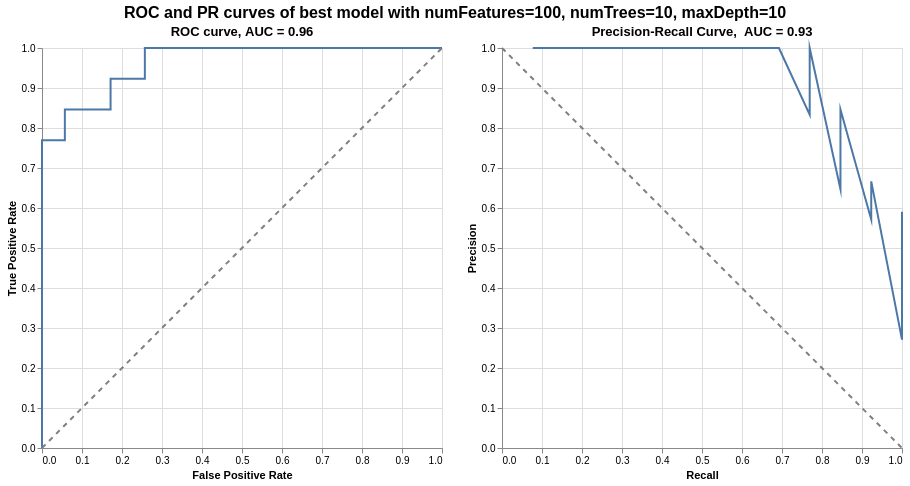

In [65]:
display(Image(filename='./images/roc-pr.png'))  # For GitHub

In [66]:
# Binning predicted probabilities
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
best_preds_pd_df = best_preds_df.toPandas()
best_preds_pd_df['prob0_bin'] = pd.cut(best_preds_pd_df['prob0'], bins=bins, right=False).astype(str)
best_preds_pd_df['prob1_bin'] = pd.cut(best_preds_pd_df['prob1'], bins=bins, right=False).astype(str)
best_preds_pd_df.head()[["prob0", "prob0_bin", "prob1", "prob1_bin"]]

,prob0,prob0_bin,prob1,prob1_bin
0,0.736,"[0.7, 0.8)",0.264,"[0.2, 0.3)"
1,0.557,"[0.5, 0.6)",0.443,"[0.4, 0.5)"
2,0.232,"[0.2, 0.3)",0.768,"[0.7, 0.8)"
3,0.660,"[0.6, 0.7)",0.340,"[0.3, 0.4)"
4,0.543,"[0.5, 0.6)",0.457,"[0.4, 0.5)"


In [67]:
# Plotting predicted probabilities distribution, binned

# When user is a human (bot = False)
prob0 = alt.Chart(best_preds_pd_df).mark_bar().encode(
    x=alt.X("prob0_bin", title="Accuracy", type="nominal", axis=alt.Axis(labelAngle=0)),
    y=alt.Y("count(*)", type="quantitative", title="Count")
).properties(
    title="User is a human",
    width=500,
    height=300
)

# When user is a bot (bot = True)
prob1 = alt.Chart(best_preds_pd_df).mark_bar().encode(
    x=alt.X("prob1_bin", title="Accuracy", type="nominal", axis=alt.Axis(labelAngle=0)),
    y=alt.Y("count(*)", type="quantitative", title="Count")
).properties(
    title="User is a bot",
    width=500,
    height=300
)

# Plotting
(prob0 | prob1).properties(
    title=alt.Title(
        "Distribution of binned predicted probabilities for both types of users",
        anchor="middle",
        fontSize=20,
        fontWeight='bolder'
    )
)

alt.HConcatChart(...)

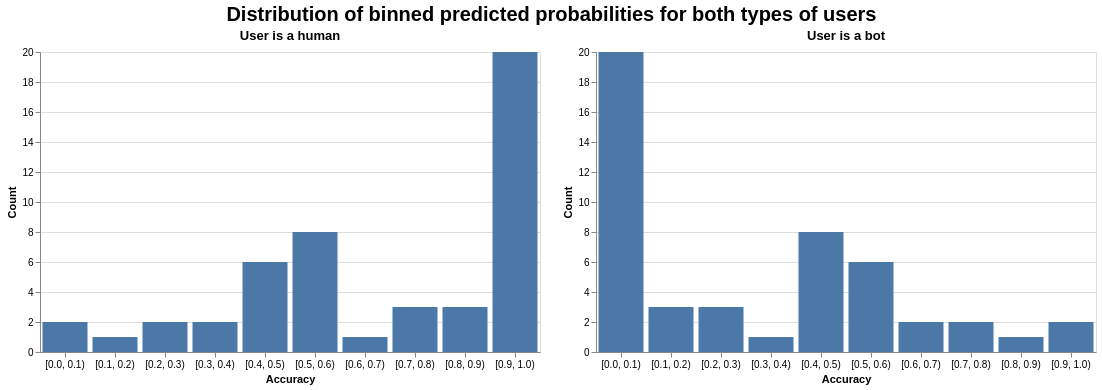

In [68]:
display(Image(filename='./images/probabilities.png'))  # For GitHub

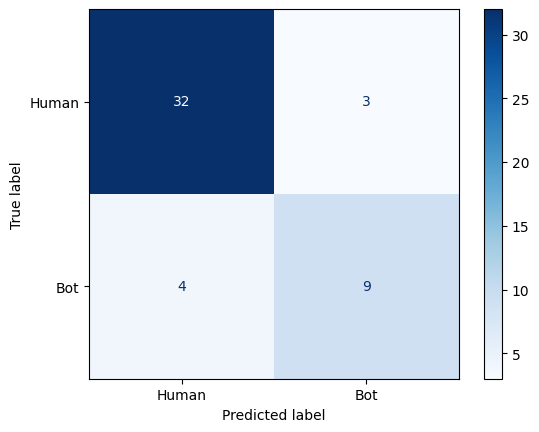

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(best_preds_pd_df["bot"], best_preds_pd_df["prediction"])
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human", "Bot"]).plot(cmap='Blues')

In [70]:
# Saving the model
best_model.write().overwrite().save("/home/ubuntu/PycharmProjects/mmds/model")

---

# Bloom Filter

---

### Installing and importing required libraries

In [71]:
!pip install mmh3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 4.2 MB/s eta 0:00:00


In [72]:
import math
import mmh3
import random

## Defining helper functions

In [73]:
def find_optimal_filter_size(expected_n, expected_fpr):
    """
    Finds the required number of bits in the filter.

    Parameters:
    expected_n (int): The expected number of elements to store.
    expected_fpr (float): The desired false positive rate.

    Returns:
    int: The optimal filter size in bits.
    """
    return int(-(expected_n * math.log(expected_fpr) / math.log(2)**2))


def find_optimal_n_hashes(expected_n, filter_size):
    """
    Finds the optimal number of hash functions.

    Parameters:
    expected_n (int): The expected number of elements to store.
    filter_size (int): The number of bits in the filter.

    Returns:
    int: The optimal number of hash functions.
    """
    return int(math.log(2) * (filter_size / expected_n))


def randomHash(expected_n, expected_fpr):
    """Generates a random hash function"""
    filter_size = find_optimal_filter_size(expected_n, expected_fpr)
    a, b = random.randint(1, filter_size - 1), random.randint(1, filter_size - 1)
    def f(x):
        return mmh3.hash(x, seed=42) % (a + b) % filter_size
    return f


def train_bloom_filter(expected_n, expected_fpr, bots_blacklist):
    """Creating bit-array of the bloom filter based on the bots to be blacklisted"""
    filter_size =  find_optimal_filter_size(expected_n, expected_fpr)
    num_hashes = find_optimal_n_hashes(expected_n, filter_size)

    bitarray = [0] * filter_size # define the bit array of desired length

    # generate optimal amount of random hash functions
    hashes = [randomHash(expected_n, expected_fpr) for _ in range(num_hashes)]

    # Loop over all bots in the blacklist and add them to the bloom filter
    for bot in bots_blacklist:
        for i in range(0,num_hashes):
            k = hashes[i](bot)
            bitarray[k] = 1

    return bitarray, hashes

### Checking overlap of predicted bots

In [74]:
predicted_bots = best_preds_pd_df[best_preds_pd_df["prediction"] == True]["user"].unique()
real_bots = best_preds_pd_df[best_preds_pd_df["bot"] == True]["user"].unique()
print("Predicted bots count:", len(predicted_bots))
print("Real bots count:", len(real_bots))
print("Shared bots count:", len(set(predicted_bots) & set(real_bots)))

Predicted bots count: 12
Real bots count: 13
Shared bots count: 9


### Training bloom filter

In [75]:
bitarray, hashes = train_bloom_filter(expected_n=len(predicted_bots), expected_fpr=0.1, bots_blacklist=predicted_bots)
print("Filter size:", len(bitarray))
print("Number of hash functions:", len(hashes))

Filter size: 57
Number of hash functions: 3


In [76]:
import cloudpickle

# Saving filter's bitarray and hash functions
with open('bloom_filter.pkl', 'wb') as f:
    cloudpickle.dump((bitarray, hashes), f)